In [339]:
import pandas as pd
import sklearn
import numpy as np

In [340]:
df=pd.read_csv('Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv')

Historical customer attributes at your disposal include:
- Recency: Months since last purchase.
- History_Segment: Categorization of dollars spent in the past year.
- History: Actual dollar value spent in the past year.
- Mens: 1/0 indicator, 1 = customer purchased Mens merchandise in the past year.
- Womens: 1/0 indicator, 1 = customer purchased Womens merchandise in the past year.
- Zip_Code: Classifies zip code as Urban, Suburban, or Rural.
- Newbie: 1/0 indicator, 1 = New customer in the past twelve months.
- Channel: Describes the channels the customer purchased from in the past year.

Another variable describes the e-mail campaign the customer received:
- Segment (Mens E-Mail,  Womens E-Mail, No E-Mail)

Finally, we have a series of variables describing activity in the two weeks following delivery of the e-mail campaign:
- Visit: 1/0 indicator, 1 = Customer visited website in the following two weeks.
- Conversion: 1/0 indicator, 1 = Customer purchased merchandise in the following two weeks.
- Spend: Actual dollars spent in the following two weeks.

In [341]:
df.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0


## Feature Engineering

In [342]:
df.drop(['history_segment', "conversion", "spend"], axis=1, inplace=True) 

In [343]:
import category_encoders as ce
cat_cols=['zip_code', 'channel']  
ce_one_hot = ce.OneHotEncoder(cols = cat_cols, use_cat_names=True)
data_ohe=ce_one_hot.fit_transform(df)

In [344]:
data_ohe.segment= data_ohe.segment.map({'Womens E-Mail': 1, 'Mens E-Mail': 1, 'No E-Mail': 0})

In [345]:
data=data_ohe.copy()
X=data_ohe.drop('visit', axis=1)
y=data_ohe.visit

In [346]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X,y, test_size=0.2, stratify=y, random_state=42)

## Upsampling

In [347]:
import imblearn
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)

## Gradient Boosting

In [348]:
from sklearn.ensemble import GradientBoostingClassifier

model_gb=GradientBoostingClassifier(n_estimators=100)

In [349]:
model_gb.fit(X_train_smote, y_train_smote)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [350]:
model_gb.score(X_test, y_test)

0.81921875

In [351]:
y_pred=model_gb.predict(X_test)

In [352]:
sklearn.metrics.precision_score(y_pred, y_test)

0.08036189462480042

In [353]:
sklearn.metrics.f1_score(y_pred, y_test)

0.1154434250764526

In [354]:
y_proba=model_gb.predict_proba(X_test)

In [355]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test,y_proba[:,1] )

In [356]:
average_precision

0.18839375747430293

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.19')

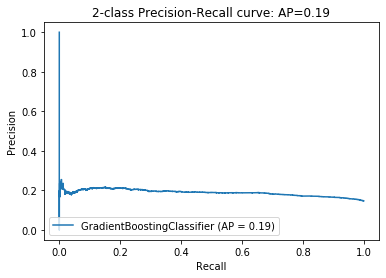

In [358]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(model_gb, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

## Uplift package

In [359]:
#!pip install pyuplift
from pyuplift.variable_selection import TwoModel
model = TwoModel()
model.fit(X_train.drop(['segment'],axis=1).values, y_train.values, X_train.segment.values)
uplift = model.predict(X_test.drop(['segment'],axis=1).values)
print(uplift)

[0.0461692  0.04484628 0.07853125 ... 0.05125481 0.02584018 0.085295  ]


In [360]:
average_precision = average_precision_score(y_test,uplift)

In [361]:
average_precision

0.18632232351122727

## AutoML tool

from tpot import TPOTClassifier

tpot = TPOTClassifier(generations=1,verbosity=2, scoring='f1', cv=5, n_jobs=-1, 
                      population_size=100, warm_start=True)

tpot.fit(X_train, y_train)

tpot.export('uplift_pipeline_tpot3_f1.py')

In [362]:
import numpy as np
import pandas as pd
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

# Average CV score on the training set was: 0.29306775730469486
exported_pipeline = make_pipeline(
    MinMaxScaler(),
    BernoulliNB(alpha=10.0, fit_prior=False)
)

exported_pipeline.fit(X_train, y_train)
results = exported_pipeline.predict(X_test)


In [363]:
sklearn.metrics.precision_score(y_test,results)

0.1949307987326997

In [364]:
sklearn.metrics.f1_score(y_test,results)

0.2968511934992382

## Ceteris Paribus

In [400]:
from ceteris_paribus.explainer import explain
explainer_gb = explain(model_gb, data=X_train, y=y_train, label='XGBoost',
    predict_function=lambda X: model_gb.predict_proba(X)[::, 1])

explainer_uplift = explain(model, data=X_train.drop('segment', axis=1), y=y_train, label='Uplift',
    predict_function=lambda X: model.predict(X))

explainer_nb = explain(exported_pipeline, data=X_train, y=y_train, label='Naive_Bayes',
    predict_function=lambda X: exported_pipeline.predict_proba(X)[::,1])

In [391]:
def select_obs (index, uplift=None):
    if uplift=='Yes':
        return X_test.iloc[index,:].drop('segment'), y_test.iloc[index]
    return X_test.iloc[index,:], y_test.iloc[index]

def individual_profile(explainer, index, uplift=None):
    return individual_variable_profile(explainer, select_obs(index, uplift)[0])

def plot_ceteris (cp):
    plot(cp, selected_variables=['history'])

In [403]:
obs1, label_obs1 = select_obs(1)
obs101, label_obs101 = select_obs(101)

from ceteris_paribus.profiles import individual_variable_profile
cp_1_gb = individual_profile(explainer_gb, 1)
cp_101_gb = individual_profile(explainer_gb, 101)

cp_1_up = individual_profile(explainer_uplift, 1, 'Yes')
cp_101_up= individual_profile(explainer_uplift, 101, 'Yes')

cp_1_nb = individual_profile(explainer_nb, 1)
cp_101_nb= individual_profile(explainer_nb, 101)

In [392]:
from ceteris_paribus.plots.plots import plot_notebook, plot

for i in [cp_1_gb, cp_101_gb, cp_1_up, cp_101_up]:
    plot_ceteris(i)

In [393]:
from ceteris_paribus.select_data import select_neighbours

def pdp (obs, explainer, n=100):
    neighbours_x, neighbours_y = select_neighbours(X_test, obs, y=y_test, n=n)
    cp= individual_variable_profile(explainer,
        neighbours_x, neighbours_y)
    plot(cp, aggregate_profiles="mean", selected_variables=["history"], color_pdps='black', size_pdps=6,
         alpha_pdps=0.6, plot_title='')

In [394]:
pdp(obs1, explainer_gb)
pdp(obs101, explainer_gb)

In [405]:
plot_ceteris(cp_101_nb)